In [182]:
import pandas as pd

# import data

data = pd.read_csv("C:\\Users\\sadha\\Downloads\\Copy of Final Project_ Auditing an algorithm (Part I_ Data Collection & Analysis)  - Data.csv")


data.columns

data.columns = ['face_num', 'pred_Age', 'pred_Gender', 'pred_Race', 'detect_Age', 'detect_Gender', 'detect_Quality', 'Overall Quality', 'Additional Comments']



data.head()

data.drop('Additional Comments', axis=1, inplace = True)

data.drop('Overall Quality', axis=1, inplace = True)
data.drop(0, inplace = True)

data.head()

# fix the pred Age columns to be uniform

def parse_age(age_str):
    if pd.isna(age_str):
        return None
    
    age_str = str(age_str).lower().strip()
    
    if "-" in age_str and all(part.isdigit() for part in age_str.split("-")):
        parts = [int(p) for p in age_str.split("-")]
        return sum(parts) / 2
    elif "s" in age_str and age_str.replace("s", "").isdigit():
        return int(age_str.replace("s", "")) + 5
    elif "child" in age_str:
        return 10
    elif "teen" in age_str:
        return 16
    elif "senior" in age_str:
        return 70
    elif age_str.isdigit():
        return int(age_str)
    else:
        return None
    
data['pred_Age'] = data['pred_Age'].apply(parse_age)
data['detect_Age'] = data['detect_Age'].astype(float)

print(data.dtypes)



face_num           object
pred_Age          float64
pred_Gender        object
pred_Race          object
detect_Age        float64
detect_Gender      object
detect_Quality     object
dtype: object


In [183]:
# more data cleaning

data['pred_Gender'] = data['pred_Gender'].str.lower().str.strip()
data['pred_Race'] = data['pred_Race'].str.lower().str.strip()
data['detect_Gender'] = data['pred_Gender'].str.lower().str.strip()


data['detect_Quality'] = pd.to_numeric(data['detect_Quality'], errors='coerce')

print(data.dtypes)

# look at the unique vals in pred_Gender and pred_Race
data['pred_Gender'].unique()
data['pred_Race'].unique()

# data['pred_Race'] == 'male'
data.loc[data['pred_Race'] == 'male', 'pred_Race'] = 'white'

data['pred_Gender'].unique()
data['pred_Race'].unique()

# if pred_Age is NaN, remove the row

data = data.dropna(subset=['pred_Age'])
data['pred_Age'].isna().sum()

data['pred_Race'] = data['pred_Race'].replace('indian', 'asian')


face_num           object
pred_Age          float64
pred_Gender        object
pred_Race          object
detect_Age        float64
detect_Gender      object
detect_Quality    float64
dtype: object


In [184]:
# data anaylsis

data.shape # 86x8
data.head(20)

# average quality of results based on the predicted vs detected values for demographics:

import numpy as np

data['detect_Age'] = pd.to_numeric(data['detect_Age'], errors='coerce')

# looking at the diff in age from pred(actual) to detected(model prediction):
data['age_diff'] = (data['pred_Age'] - data['detect_Age'])

# looking at if pred_gender and detect_gender math using np.where:

condition = data['pred_Gender'] == data['detect_Gender']
# where true is 1, and 0 otherwise
data['gender_match'] = np.where(condition, 1, 0)


In [185]:
# now group by demograpghic to compare results:

avg_quality_metrics = data.groupby(['pred_Gender', 'pred_Age', 'pred_Race']).agg({'age_diff': 'mean', 
                                                                                  'gender_match': 'mean', 
                                                                                  'detect_Quality': 'mean'}).reset_index()
avg_quality_metrics = avg_quality_metrics.rename(columns={
    'age_diff': 'Avg_Age_Diff',
    'gender_match': 'Avg_Gender_Match',
    'detect_Quality': 'Avg_Detect_Quality'
})

avg_quality_metrics

# grouping by race category and lookin at avgs 
race_grouped = data.groupby('pred_Race').agg({
    'age_diff': 'mean',
    'detect_Quality': 'mean'
}).reset_index()

race_grouped = race_grouped.rename(columns={
    'pred_Race': 'Race Category',
    'age_diff': 'Avg_Age_Diff',
    'detect_Quality': 'Avg_Detect_Quality'
})

race_grouped


# group by gender:

gender_grouped = data.groupby('pred_Gender').agg({
    'age_diff': 'mean',
    'detect_Quality': 'mean'
}).reset_index()

gender_grouped
race_grouped


# creating bins to look at age groups and their quality metrics:

age_bins = pd.cut(data['pred_Age'], bins=[0, 25, 40, 60, 100], labels=['Young (<=25)', 'Adult (26-40)', 'Middle Aged (41-60)', 'Senior (61+)'])

age_category_group = data.groupby(age_bins).agg({
    'detect_Quality': 'mean',
    'age_diff': 'mean'
}).reset_index()

age_category_group = age_category_group.rename(columns={
    'pred_Age': 'Age Category',
    'age_diff': 'Avg_Age_Diff',
    'detect_Quality': 'Avg_Detect_Quality'
})



age_category_group

# gender_grouped
# race_grouped

C:\Users\sadha\AppData\Local\Temp\ipykernel_20980\1697537496.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_category_group = data.groupby(age_bins).agg({


,Age Category,Avg_Detect_Quality,Avg_Age_Diff
0,Young (<=25),72.829191,-2.851064
1,Adult (26-40),69.939632,1.342105
2,Middle Aged (41-60),75.287000,-5.307692
3,Senior (61+),84.435286,0.285714


In [193]:
# create a table that groups both gender and race together:

gender_race_group = data.groupby(['pred_Gender', 'pred_Race']).agg({
    'detect_Quality': 'mean',
    'age_diff': 'mean'
}).reset_index()

gender_race_group = gender_race_group.rename(columns={
    'detect_Quality': 'Avg_Detect_Quality',
    'age_diff': 'Avg_Age_Diff',
    'pred_Gender': 'Gender Category',
    'pred_Race': 'Race Category'
})

gender_race_group

,Gender Category,Race Category,Avg_Detect_Quality,Avg_Age_Diff
0,female,asian,77.391417,-1.083333
1,female,black,61.647250,-7.000000
2,female,non-white,70.328750,-1.750000
3,female,white,69.565040,-2.200000
4,male,asian,81.638000,0.250000
5,male,black,88.793500,-5.000000
6,male,non-white,72.125500,1.571429
7,male,white,73.856067,-5.100000


([0, 1, 2, 3],
 [Text(0, 0, 'asian'),
  Text(1, 0, 'black'),
  Text(2, 0, 'non-white'),
  Text(3, 0, 'white')])

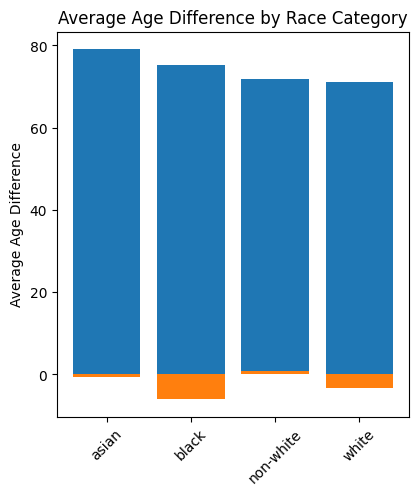

In [186]:
# create plots:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))

# detection quality by race:
plt.subplot(1, 2, 1)
plt.bar(race_grouped['Race Category'], race_grouped['Avg_Detect_Quality'])
plt.title('Avg Detection Quality by Race')
plt.ylabel('Detection Quality')
plt.xticks(rotation=45)

# predicted age by race:

plt.subplot(1, 2, 1)
plt.bar(race_grouped['Race Category'], race_grouped['Avg_Age_Diff'])
plt.title('Average Age Difference by Race Category')
plt.ylabel('Average Age Difference')
plt.xticks(rotation=45)


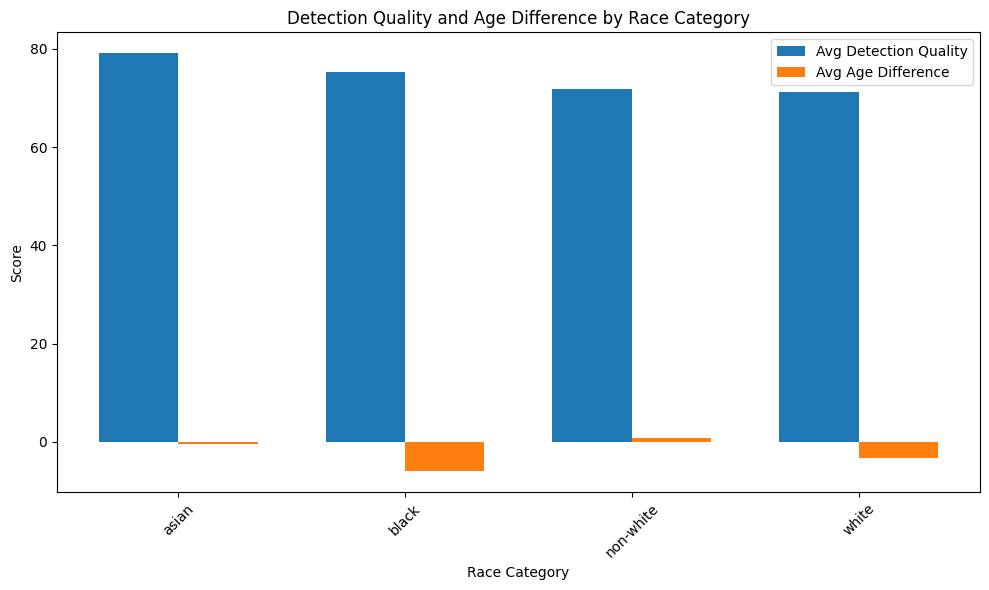

In [187]:
# sise by side bar plot:

x = np.arange(len(race_grouped))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

bar_detect_quality = ax.bar(x - width/2, race_grouped['Avg_Detect_Quality'], width, label='Avg Detection Quality')
bar_age_diff = ax.bar(x + width/2, race_grouped['Avg_Age_Diff'], width, label='Avg Age Difference')

ax.set_xlabel('Race Category')
ax.set_ylabel('Score')
ax.set_title('Detection Quality and Age Difference by Race Category')
ax.set_xticks(x)
ax.set_xticklabels(race_grouped['Race Category'], rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


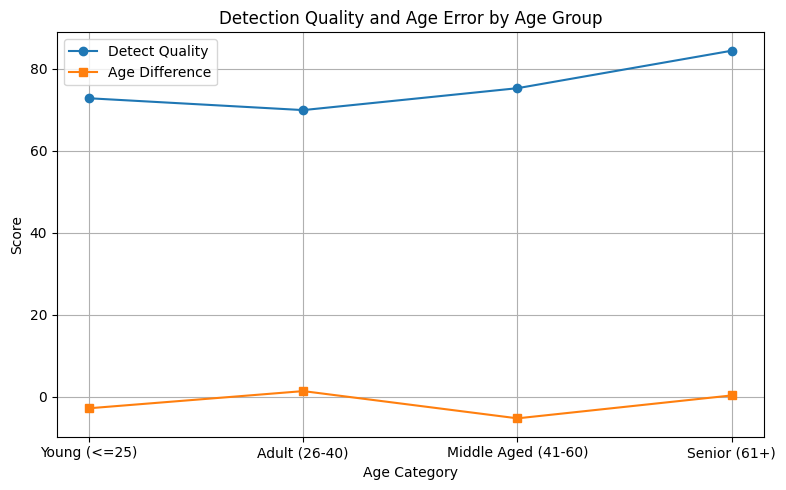

In [188]:
# antoher plot for age_category_group:


plt.figure(figsize=(8, 5))
plt.plot(age_category_group['Age Category'], age_category_group['Avg_Detect_Quality'], marker='o', label='Detect Quality')
plt.plot(age_category_group['Age Category'], age_category_group['Avg_Age_Diff'], marker='s', label='Age Difference')

plt.title("Detection Quality and Age Error by Age Group")
plt.xlabel("Age Category")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

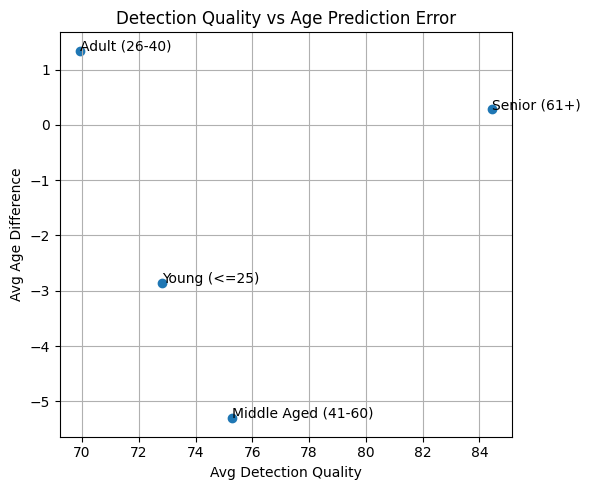

In [189]:
plt.figure(figsize=(6, 5))
plt.scatter(age_category_group['Avg_Detect_Quality'], age_category_group['Avg_Age_Diff'])

for i, label in enumerate(age_category_group['Age Category']):
    plt.annotate(label, (age_category_group['Avg_Detect_Quality'][i], age_category_group['Avg_Age_Diff'][i]))

plt.xlabel("Avg Detection Quality")
plt.ylabel("Avg Age Difference")
plt.title("Detection Quality vs Age Prediction Error")
plt.grid(True)
plt.tight_layout()
plt.show()

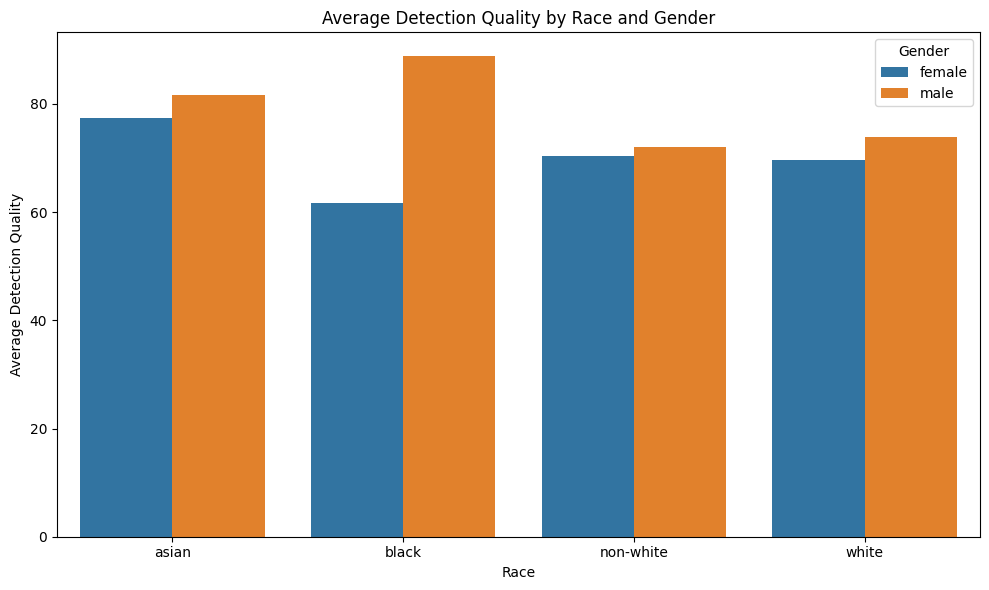

In [192]:
# plot of gender_race_group:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=gender_race_group, x='pred_Race', y='Avg_Detect_Quality', hue='pred_Gender')

plt.title('Average Detection Quality by Race and Gender')
plt.xlabel('Race')
plt.ylabel('Average Detection Quality')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

In [202]:
# looking at reliability and validity of algorithm:

# std / variance can help us understand reliability of the algorithm: (on detect_Quality)

reliability_summary = data.groupby(['pred_Gender', 'pred_Race'])['detect_Quality'].std().reset_index()
reliability_summary = reliability_summary.rename(columns={'detect_Quality': 'Quality_STD', 'age_diff':'mean'})

validity_summary = data.groupby(['pred_Gender', 'pred_Race']).agg({
    'age_diff': 'mean',
    'gender_match': 'mean'
}).reset_index()

reliability_summary
validity_summary

,pred_Gender,pred_Race,age_diff,gender_match
0,female,asian,-1.083333,1.0
1,female,black,-7.000000,1.0
2,female,non-white,-1.750000,1.0
3,female,white,-2.200000,1.0
4,male,asian,0.250000,1.0
5,male,black,-5.000000,1.0
6,male,non-white,1.571429,1.0
7,male,white,-5.100000,1.0


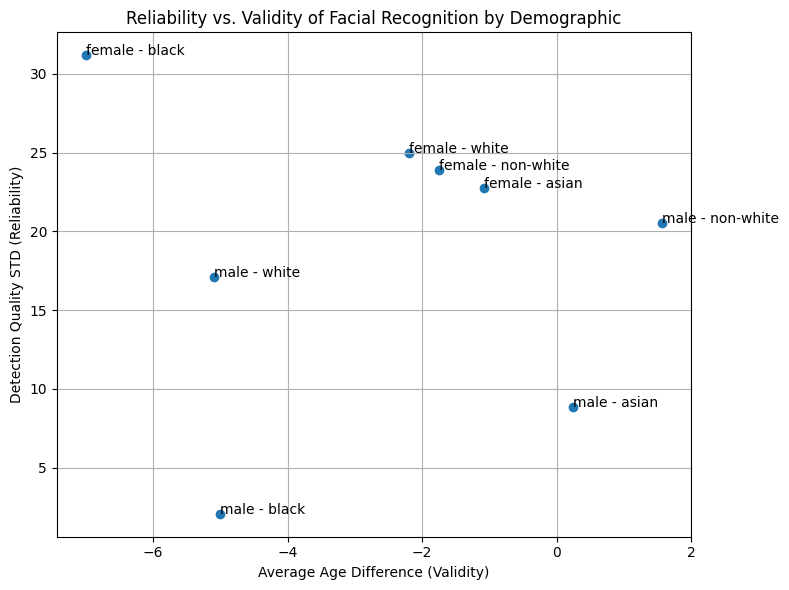

In [200]:
# plotting above:

plt.figure(figsize=(8, 6))
plt.scatter(validity_summary['age_diff'], reliability_summary['Quality_STD'])

for i in range(len(validity_summary)):
    label = f"{validity_summary['pred_Gender'][i]} - {validity_summary['pred_Race'][i]}"
    plt.annotate(label, (validity_summary['age_diff'][i], reliability_summary['Quality_STD'][i]))

plt.xlabel('Average Age Difference (Validity)')
plt.ylabel('Detection Quality STD (Reliability)')
plt.title('Reliability vs. Validity of Facial Recognition by Demographic')
plt.grid(True)
plt.tight_layout()
plt.show()